## Setting Up:

In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '../../')) # Add root of repo to import MBM

import pandas as pd
import warnings
from tqdm.notebook import tqdm
import re
import matplotlib.pyplot as plt
import seaborn as sns
from cmcrameri import cm
import xarray as xr
import massbalancemachine as mbm
from collections import defaultdict
import logging
import torch.nn as nn
from skorch.helper import SliceDataset
from datetime import datetime
from skorch.callbacks import EarlyStopping, LRScheduler, Checkpoint
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset
import pickle 

from scripts.helpers import *
from scripts.iceland_preprocess import *
from scripts.plots import *
from scripts.config_ICE import *
from scripts.nn_helpers import *
from scripts.xgb_helpers import *
from scripts.NN_networks import *

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

# Initialize logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

cfg = mbm.IcelandConfig(dataPath='/home/mburlet/scratch/data/DATA_MB/WGMS/Iceland/')

In [2]:
seed_all(cfg.seed)
free_up_cuda()

# Plot styles:
path_style_sheet = 'scripts/example.mplstyle'
plt.style.use(path_style_sheet)


vois_climate = [
    't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]

vois_topographical = [
    "aspect",
    "slope",
    "hugonnet_dhdt",
    "consensus_ice_thickness",
    "millan_v",
]

In [3]:
if torch.cuda.is_available():
    print("CUDA is available")
    free_up_cuda()

    # # Try to limit CPU usage of random search
    # torch.set_num_threads(2)  # or 1
    # os.environ["OMP_NUM_THREADS"] = "1"
    # os.environ["MKL_NUM_THREADS"] = "1"
else:
    print("CUDA is NOT available")


CUDA is available


## A. Read GL data:

In [15]:
data_wgms = pd.read_csv(cfg.dataPath + path_PMB_WGMS_csv + 'ICE_dataset_all_oggm_with_hugonnetdhdt.csv')

# Drop Nan entries in hugonnet_dhdt of Iceland dataset
data_wgms = data_wgms.dropna(subset=data_wgms.columns.drop('DATA_MODIFICATION'))

print('Number of glaciers:', len(data_wgms['GLACIER'].unique()))
print('Number of winter, summer and annual samples:', len(data_wgms[data_wgms.PERIOD == 'annual']) + len(data_wgms[data_wgms.PERIOD == 'winter']) + len(data_wgms[data_wgms.PERIOD == 'summer']))
print('Number of annual samples:',
      len(data_wgms[data_wgms.PERIOD == 'annual']))
print('Number of winter samples:',
      len(data_wgms[data_wgms.PERIOD == 'winter']))
print('Number of summer samples:',
      len(data_wgms[data_wgms.PERIOD == 'summer']))

data_wgms.columns

Number of glaciers: 47
Number of winter, summer and annual samples: 5930
Number of annual samples: 2883
Number of winter samples: 3047
Number of summer samples: 0


Index(['POINT_ELEVATION', 'POINT_LAT', 'POINT_LON', 'DATA_MODIFICATION',
       'FROM_DATE', 'TO_DATE', 'POINT_BALANCE', 'PERIOD', 'YEAR', 'RGIId',
       'aspect', 'slope', 'topo', 'hugonnet_dhdt', 'consensus_ice_thickness',
       'millan_v', 'GLACIER', 'POINT_ID'],
      dtype='object')

## Input data:
### Input dataset:

In [16]:
data_wgms_test = data_wgms.copy()

# Transform data to monthly format (run or load data):
paths = {
    'csv_path': cfg.dataPath + path_PMB_WGMS_csv,
    'era5_climate_data': cfg.dataPath + path_ERA5_raw + 'era5_monthly_averaged_data_ICECH.nc',
    'geopotential_data': cfg.dataPath + path_ERA5_raw + 'era5_geopotential_pressure_ICECH.nc'
}

RUN = False
dataloader_gl = process_or_load_data(run_flag=RUN,
                                     df=data_wgms_test,
                                     paths=paths,
                                     cfg=cfg,
                                     vois_climate=vois_climate,
                                     vois_topographical=vois_topographical,
                                     output_file='ICE_dataset_monthly_full_with_hugonnetdhdt.csv')
data_monthly = dataloader_gl.data

display(data_monthly.head(2))
"""
data_monthly['GLWD_ID'] = data_monthly.apply(
    lambda x: mbm.data_processing.utils.get_hash(f"{x.GLACIER}_{x.YEAR}"),
    axis=1)
data_monthly['GLWD_ID'] = data_monthly['GLWD_ID'].astype(str)

dataloader_gl = mbm.dataloader.DataLoader(cfg,
                                          data=data_monthly,
                                          random_seed=cfg.seed,
                                          meta_data_columns=cfg.metaData)
"""

2025-09-09 15:21:40,393 - INFO - Loaded preprocessed data.
2025-09-09 15:21:40,395 - INFO - Number of monthly rows: 56209
2025-09-09 15:21:40,403 - INFO - Number of annual samples: 34915
2025-09-09 15:21:40,408 - INFO - Number of winter samples: 21294


,YEAR,POINT_LON,POINT_LAT,POINT_BALANCE,ALTITUDE_CLIMATE,ELEVATION_DIFFERENCE,POINT_ELEVATION,RGIId,POINT_ID,ID,...,millan_v,t2m,tp,slhf,sshf,ssrd,fal,str,u10,v10
0,1989.0,-18.595688,64.790063,0.45,1094.738918,-45.138918,1049.6,RGI60-06.00234,Thjorsarjoekull (Hofsjoekull E)_1989.0_annual_...,0,...,25.446609,-4.787933,0.003747,198886.0,590722.0,3990646.0,0.84564,-1779436.0,-0.590102,0.603381
1,1989.0,-18.595688,64.790063,0.45,1094.738918,-45.138918,1049.6,RGI60-06.00234,Thjorsarjoekull (Hofsjoekull E)_1989.0_annual_...,0,...,25.446609,-5.262054,0.003766,306376.0,576896.0,883468.0,0.84690,-1458576.0,0.129348,2.214950


'\ndata_monthly[\'GLWD_ID\'] = data_monthly.apply(\n    lambda x: mbm.data_processing.utils.get_hash(f"{x.GLACIER}_{x.YEAR}"),\n    axis=1)\ndata_monthly[\'GLWD_ID\'] = data_monthly[\'GLWD_ID\'].astype(str)\n\ndataloader_gl = mbm.dataloader.DataLoader(cfg,\n                                          data=data_monthly,\n                                          random_seed=cfg.seed,\n                                          meta_data_columns=cfg.metaData)\n'

In [13]:
display(data_monthly[data_monthly.isna().any(axis=1)])
display(data_monthly['GLACIER'].nunique())

,YEAR,POINT_LON,POINT_LAT,POINT_BALANCE,ALTITUDE_CLIMATE,ELEVATION_DIFFERENCE,POINT_ELEVATION,RGIId,POINT_ID,ID,...,millan_v,t2m,tp,slhf,sshf,ssrd,fal,str,u10,v10


47

## Blocking on glaciers:

In [7]:
# These are the two icecaps to the west
Langjokul = dataloader_gl.data[
    (dataloader_gl.data['POINT_LON'] < -19.4) & 
    (dataloader_gl.data['POINT_LAT'] > 64.3)
]['GLACIER'].unique()
display(Langjokul)

array(['Hagafellsjoekull West', 'RGI60-06.00303', 'Langjoekull Ice Cap',
       'RGI60-06.00302', 'Hagafellsjoekull East (Langjoekull S Dome)',
       'RGI60-06.00294', 'RGI60-06.00292', 'RGI60-06.00301',
       'RGI60-06.00311', 'RGI60-06.00305', 'RGI60-06.00306',
       'RGI60-06.00296'], dtype=object)

In [19]:
"""
test_glaciers = ['Hagafellsjoekull West', 'RGI60-06.00303', 'Langjoekull Ice Cap',
       'RGI60-06.00302', 'Hagafellsjoekull East (Langjoekull S Dome)',
       'RGI60-06.00294', 'RGI60-06.00292', 'RGI60-06.00301',
       'RGI60-06.00311', 'RGI60-06.00305', 'RGI60-06.00306',
       'RGI60-06.00296']
"""

# 50%
test_glaciers = ['Thjorsarjoekull (Hofsjoekull E)', 'Breidamerkurjoekull', 'Dyngjujoekull', 'RGI60-06.00328',
                    'Tungnaarjoekull', 'Eyjabakkajoekull', 'RGI60-06.00303', 'Langjoekull Ice Cap', 'Oeldufellsjoekull',
                    'RGI60-06.00466', 'RGI60-06.00411', 'RGI60-06.00302', 'RGI60-06.00359', 'RGI60-06.00340',
                    'Blagnipujoekull (Hofsjoekull SW)', 'RGI60-06.00320', 'Hagafellsjoekull East (Langjoekull S Dome)',
                    'RGI60-06.00342', 'RGI60-06.00480', 'RGI60-06.00465', 'RGI60-06.00294', 'RGI60-06.00292',
                    'RGI60-06.00232', 'RGI60-06.00478', 'Mulajoekull', 'RGI60-06.00301', 'RGI60-06.00413',
                    'RGI60-06.00311', 'RGI60-06.00350', 'RGI60-06.00476', 'RGI60-06.00228', 'RGI60-06.00409',
                    'RGI60-06.00349', 'RGI60-06.00422', 'RGI60-06.00305', 'RGI60-06.00425', 'RGI60-06.00306',
                    'RGI60-06.00479', 'RGI60-06.00296', 'RGI60-06.00445', 'RGI60-06.00474']


"""
# 5-10%
test_glaciers = ['Thjorsarjoekull (Hofsjoekull E)', 'Breidamerkurjoekull', 'Dyngjujoekull', 'RGI60-06.00328',
                 'Hagafellsjoekull West', 'Eyjabakkajoekull', 'RGI60-06.00303', 'Langjoekull Ice Cap', 'Koeldukvislarjoekull',
                 'Oeldufellsjoekull', 'Skeidararjoekull', 'RGI60-06.00466', 'RGI60-06.00411', 'RGI60-06.00302', 'RGI60-06.00359',
                 'RGI60-06.00340', 'Bruarjoekull', 'Blagnipujoekull (Hofsjoekull SW)', 'RGI60-06.00238', 'RGI60-06.00320',
                 'RGI60-06.00342', 'RGI60-06.00480', 'RGI60-06.00465', 'RGI60-06.00294', 'RGI60-06.00292', 'RGI60-06.00232',
                 'RGI60-06.00301', 'RGI60-06.00413', 'RGI60-06.00311', 'RGI60-06.00350', 'RGI60-06.00476', 'RGI60-06.00228',
                 'RGI60-06.00409', 'RGI60-06.00349', 'RGI60-06.00422', 'RGI60-06.00305', 'RGI60-06.00425', 'RGI60-06.00306',
                 'RGI60-06.00479', 'RGI60-06.00296', 'RGI60-06.00445', 'RGI60-06.00474']
"""
"""
# about 75%
test_glaciers = ['RGI60-06.00311', 'RGI60-06.00305', 'Thjorsarjoekull (Hofsjoekull E)','RGI60-06.00445',
                 'RGI60-06.00474','RGI60-06.00425','RGI60-06.00480','Dyngjujoekull', 'RGI60-06.00478',
                 'Koeldukvislarjoekull', 'Oeldufellsjoekull', 'RGI60-06.00350', 'RGI60-06.00340']
"""
# Ensure all test glaciers exist in the dataset
existing_glaciers = set(dataloader_gl.data.GLACIER.unique())
missing_glaciers = [g for g in test_glaciers if g not in existing_glaciers]

if missing_glaciers:
    print(
        f"Warning: The following test glaciers are not in the dataset: {missing_glaciers}"
    )

# Define training glaciers
train_glaciers = [i for i in existing_glaciers if i not in test_glaciers]
data_test = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(test_glaciers)]

# Statistics prints
print('Size of test data:', len(data_test))
data_train = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(
    train_glaciers)]
print('Size of train data:', len(data_train))
if len(data_train) == 0:
    print("Warning: No training data available!")
else:
    test_perc = (len(data_test) / len(data_train)) * 100
    print('Percentage of test size: {:.2f}%'.format(test_perc))

## CV Splits
splits, test_set, train_set = get_CV_splits(dataloader_gl,
                                            test_split_on='GLACIER',
                                            test_splits=test_glaciers,
                                            random_state=cfg.seed)
    
print('Train glaciers: ({}) {}'.format(len(train_set['splits_vals']),
                                      train_set['splits_vals']))
print('Test glaciers: ({}) {}'.format(len(test_set['splits_vals']),
                                      test_set['splits_vals']))

Size of test data: 29766
Size of train data: 26443
Percentage of test size: 112.57%
Train glaciers: (6) ['Hagafellsjoekull West' 'Koeldukvislarjoekull' 'Skeidararjoekull'
 'Slettjoekull West' 'Bruarjoekull' 'RGI60-06.00238']
Test glaciers: (41) ['Thjorsarjoekull (Hofsjoekull E)' 'Breidamerkurjoekull' 'Dyngjujoekull'
 'RGI60-06.00328' 'Tungnaarjoekull' 'Eyjabakkajoekull' 'RGI60-06.00303'
 'Langjoekull Ice Cap' 'Oeldufellsjoekull' 'RGI60-06.00466'
 'RGI60-06.00411' 'RGI60-06.00302' 'RGI60-06.00359' 'RGI60-06.00340'
 'Blagnipujoekull (Hofsjoekull SW)' 'RGI60-06.00320'
 'Hagafellsjoekull East (Langjoekull S Dome)' 'RGI60-06.00342'
 'RGI60-06.00480' 'RGI60-06.00465' 'RGI60-06.00294' 'RGI60-06.00292'
 'RGI60-06.00232' 'RGI60-06.00478' 'Mulajoekull' 'RGI60-06.00301'
 'RGI60-06.00413' 'RGI60-06.00311' 'RGI60-06.00350' 'RGI60-06.00476'
 'RGI60-06.00228' 'RGI60-06.00409' 'RGI60-06.00349' 'RGI60-06.00422'
 'RGI60-06.00305' 'RGI60-06.00425' 'RGI60-06.00306' 'RGI60-06.00479'
 'RGI60-06.00296' 'RGI6

In [8]:
from scipy.stats import ks_2samp

print("Train rows:", len(data_train), "Test rows:", len(data_test),
      "Ratio train/test rows ≈", round(len(data_train)/max(1,len(data_test)),2))
print("Train glaciers:", len(train_glaciers), "Test glaciers:", len(test_glaciers))

features = ['ELEVATION_DIFFERENCE', 't2m', 'ssrd', 'POINT_LAT', 'POINT_LON']   # extend if needed

# 4) Diagnostics: KS test for each feature
print("\nKS p-values (train vs test) for key features:")
for f in features:
    p = ks_2samp(data_train[f].dropna(), data_test[f].dropna()).pvalue
    print(f, "KS p:", p, "train mean/std:", data_train[f].mean(), data_train[f].std(),
          "test mean/std:", data_test[f].mean(), data_test[f].std())

Train rows: 43629 Test rows: 12580 Ratio train/test rows ≈ 3.47
Train glaciers: 34 Test glaciers: 13

KS p-values (train vs test) for key features:
ELEVATION_DIFFERENCE KS p: 4.652773523645322e-180 train mean/std: 64.87235949502555 180.53436641660196 test mean/std: 76.16487146868431 176.64923856711948
t2m KS p: 3.792681468068494e-24 train mean/std: -4.401660375606678 4.618733356827206 test mean/std: -4.882045434123951 4.592985737023443
ssrd KS p: 0.009015070405853707 train mean/std: 7487157.266869513 7290773.599431248 test mean/std: 7526344.8575417325 7351878.467764512
POINT_LAT KS p: 0.0 train mean/std: 64.62202676091017 0.24195819522642653 test mean/std: 64.60983745693792 0.2499916792898949
POINT_LON KS p: 0.0 train mean/std: -18.107720279885736 1.6029625227701234 test mean/std: -18.097037189988054 1.1548348905132042


In [9]:
# Validation and train split:
data_train = train_set['df_X']
data_train['y'] = train_set['y']
dataloader = mbm.dataloader.DataLoader(cfg, data=data_train)

train_itr, val_itr = dataloader.set_train_test_split(test_size=0.2)

# Get all indices of the training and valing dataset at once from the iterators. Once called, the iterators are empty.
train_indices, val_indices = list(train_itr), list(val_itr)

df_X_train = data_train.iloc[train_indices]
y_train = df_X_train['POINT_BALANCE'].values

# Get val set
df_X_val = data_train.iloc[val_indices]
y_val = df_X_val['POINT_BALANCE'].values

## B. CH Transfer

In [4]:
data_CH = pd.read_csv('/home/mburlet/scratch/data/DATA_MB/CH_wgms_dataset_all_04_06_oggm.csv')
data_ICE = pd.read_csv('/home/mburlet/scratch/data/DATA_MB/WGMS/Iceland/csv/ICE_dataset_all_oggm_with_hugonnetdhdt.csv')

# Drop Nan entries in hugonnetdhdt of Iceland dataset
data_ICE = data_ICE.dropna(subset=data_ICE.columns.drop('DATA_MODIFICATION'))
display(data_CH.columns)

display(data_ICE.columns)

data_CH = data_CH.drop(['aspect_sgi', 'slope_sgi', 'topo_sgi'], axis=1)

display(data_CH.columns)

# Merge CH with ICE
data_ICE_CH = pd.concat([data_ICE, data_CH], axis=0).reset_index(drop=True)

display(data_ICE_CH)

display(len(data_ICE_CH['GLACIER'].unique()))

Index(['YEAR', 'POINT_ID', 'GLACIER', 'FROM_DATE', 'TO_DATE', 'POINT_LAT',
       'POINT_LON', 'POINT_ELEVATION', 'POINT_BALANCE', 'PERIOD', 'RGIId',
       'aspect', 'slope', 'topo', 'hugonnet_dhdt', 'consensus_ice_thickness',
       'millan_v', 'aspect_sgi', 'slope_sgi', 'topo_sgi'],
      dtype='object')

Index(['POINT_ELEVATION', 'POINT_LAT', 'POINT_LON', 'DATA_MODIFICATION',
       'FROM_DATE', 'TO_DATE', 'POINT_BALANCE', 'PERIOD', 'YEAR', 'RGIId',
       'aspect', 'slope', 'topo', 'hugonnet_dhdt', 'consensus_ice_thickness',
       'millan_v', 'GLACIER', 'POINT_ID'],
      dtype='object')

Index(['YEAR', 'POINT_ID', 'GLACIER', 'FROM_DATE', 'TO_DATE', 'POINT_LAT',
       'POINT_LON', 'POINT_ELEVATION', 'POINT_BALANCE', 'PERIOD', 'RGIId',
       'aspect', 'slope', 'topo', 'hugonnet_dhdt', 'consensus_ice_thickness',
       'millan_v'],
      dtype='object')

,POINT_ELEVATION,POINT_LAT,POINT_LON,DATA_MODIFICATION,FROM_DATE,TO_DATE,POINT_BALANCE,PERIOD,YEAR,RGIId,aspect,slope,topo,hugonnet_dhdt,consensus_ice_thickness,millan_v,GLACIER,POINT_ID
0,1049.600000,64.790063,-18.595688,NaN,19880920,19890922,0.450,annual,1989.0,RGI60-06.00234,158.071560,2.508572,1034.505493,-0.959929,270.877716,25.446609,Thjorsarjoekull (Hofsjoekull E),Thjorsarjoekull (Hofsjoekull E)_1989.0_annual_...
1,1049.400000,64.790063,-18.595688,NaN,19890922,19900916,-0.800,annual,1990.0,RGI60-06.00234,158.071560,2.508572,1034.505493,-0.959929,270.877716,25.446609,Thjorsarjoekull (Hofsjoekull E),Thjorsarjoekull (Hofsjoekull E)_1990.0_annual_...
2,1049.100000,64.790063,-18.595688,NaN,19900916,19910912,-2.370,annual,1991.0,RGI60-06.00234,158.071560,2.508572,1034.505493,-0.959929,270.877716,25.446609,Thjorsarjoekull (Hofsjoekull E),Thjorsarjoekull (Hofsjoekull E)_1991.0_annual_...
3,1048.900000,64.790063,-18.595688,NaN,19910912,19920920,0.650,annual,1992.0,RGI60-06.00234,158.071560,2.508572,1034.505493,-0.959929,270.877716,25.446609,Thjorsarjoekull (Hofsjoekull E),Thjorsarjoekull (Hofsjoekull E)_1992.0_annual_...
4,1048.600000,64.790063,-18.595688,NaN,19920920,19930917,-0.060,annual,1993.0,RGI60-06.00234,158.071560,2.508572,1034.505493,-0.959929,270.877716,25.446609,Thjorsarjoekull (Hofsjoekull E),Thjorsarjoekull (Hofsjoekull E)_1993.0_annual_...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39283,2719.029662,46.880313,9.172743,NaN,20141009,20151010,-1.980,annual,2015.0,RGI60-11.00752,91.984261,6.554848,2690.000000,-1.459144,67.452751,41.664326,vorab,vorab_1
39284,2718.029662,46.880313,9.172743,NaN,20151010,20160823,-1.350,annual,2016.0,RGI60-11.00752,91.984261,6.554848,2690.000000,-1.459144,67.452751,41.664326,vorab,vorab_1
39285,2730.566173,46.540533,8.478626,NaN,20021004,20030816,-2.610,annual,2003.0,RGI60-11.01522,14.338433,9.574045,2575.000000,-1.626393,35.471848,3.076150,witenwasseren,witenwasseren_2
39286,2673.577794,46.536711,8.476532,NaN,20021004,20030816,-2.151,annual,2003.0,RGI60-11.01522,14.749734,9.972176,2646.000000,-1.567070,54.301399,1.453268,witenwasseren,witenwasseren_0


86

In [5]:
data_CH_ICE_test = data_ICE_CH.copy()


# Initialize logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

# Transform data to monthly format (run or load data):
paths = {
    'csv_path': cfg.dataPath + path_PMB_WGMS_csv,
    'era5_climate_data': cfg.dataPath + path_ERA5_raw + 'era5_monthly_averaged_data_ICECH.nc',
    'geopotential_data': cfg.dataPath + path_ERA5_raw + 'era5_geopotential_pressure_ICECH.nc'
}

RUN = False
dataloader_gl = process_or_load_data(run_flag=RUN,
                                     df=data_CH_ICE_test,
                                     paths=paths,
                                     cfg=cfg,
                                     vois_climate=vois_climate,
                                     vois_topographical=vois_topographical,
                                     output_file= 'CH_ICE_wgms_dataset_monthly_full_with_hugonnetdhdt.csv')
data_monthly_CH_ICE = dataloader_gl.data

display(data_monthly_CH_ICE)

2025-09-07 21:14:57,029 - INFO - Loaded preprocessed data.
2025-09-07 21:14:57,031 - INFO - Number of monthly rows: 346891
2025-09-07 21:14:57,067 - INFO - Number of annual samples: 122355
2025-09-07 21:14:57,100 - INFO - Number of winter samples: 224536


,YEAR,POINT_LON,POINT_LAT,POINT_BALANCE,ALTITUDE_CLIMATE,ELEVATION_DIFFERENCE,POINT_ELEVATION,RGIId,POINT_ID,ID,...,millan_v,t2m,tp,slhf,sshf,ssrd,fal,str,u10,v10
0,1989.0,-18.595688,64.790063,0.450,1094.738918,-45.138918,1049.600000,RGI60-06.00234,Thjorsarjoekull (Hofsjoekull E)_1989.0_annual_...,0,...,25.446609,-4.787933,0.003747,198886.0,590722.0,3990646.0,0.845640,-1779436.0,-0.590102,0.603381
1,1989.0,-18.595688,64.790063,0.450,1094.738918,-45.138918,1049.600000,RGI60-06.00234,Thjorsarjoekull (Hofsjoekull E)_1989.0_annual_...,0,...,25.446609,-5.262054,0.003766,306376.0,576896.0,883468.0,0.846900,-1458576.0,0.129348,2.214950
2,1989.0,-18.595688,64.790063,0.450,1094.738918,-45.138918,1049.600000,RGI60-06.00234,Thjorsarjoekull (Hofsjoekull E)_1989.0_annual_...,0,...,25.446609,-7.606537,0.006315,444538.0,1094154.0,128956.0,0.849206,-1698892.0,0.674374,2.860879
3,1989.0,-18.595688,64.790063,0.450,1094.738918,-45.138918,1049.600000,RGI60-06.00234,Thjorsarjoekull (Hofsjoekull E)_1989.0_annual_...,0,...,25.446609,-7.970551,0.008424,400102.0,1158194.0,463140.0,0.850101,-2003835.0,0.580868,3.494255
4,1989.0,-18.595688,64.790063,0.450,1094.738918,-45.138918,1049.600000,RGI60-06.00234,Thjorsarjoekull (Hofsjoekull E)_1989.0_annual_...,0,...,25.446609,-11.772552,0.005670,189816.0,1210372.0,2744842.0,0.850184,-2384183.0,-0.110946,0.831824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346886,2003.0,8.475240,46.535284,-1.998,2171.442724,531.139915,2702.582638,RGI60-11.01522,witenwasseren_1,39287,...,5.635539,-3.171478,0.003812,-653086.0,-1620794.0,20613876.0,0.676411,-3674161.0,0.171637,-0.126322
346887,2003.0,8.475240,46.535284,-1.998,2171.442724,531.139915,2702.582638,RGI60-11.01522,witenwasseren_1,39287,...,5.635539,3.248199,0.003879,-244852.0,-1247730.0,21740796.0,0.574618,-2969440.0,0.122689,0.119759
346888,2003.0,8.475240,46.535284,-1.998,2171.442724,531.139915,2702.582638,RGI60-11.01522,witenwasseren_1,39287,...,5.635539,10.955475,0.005219,-2339854.0,-1488806.0,22393936.0,0.366976,-3366256.0,0.218174,-0.193396
346889,2003.0,8.475240,46.535284,-1.998,2171.442724,531.139915,2702.582638,RGI60-11.01522,witenwasseren_1,39287,...,5.635539,10.427399,0.005787,-7321654.0,-3450182.0,21336846.0,0.169596,-5809211.0,0.187729,-0.488665


In [6]:
#test_glaciers = list(data_ICE['GLACIER'].unique())

"""
# 50% set
test_glaciers = ['Thjorsarjoekull (Hofsjoekull E)', 'Breidamerkurjoekull', 'Dyngjujoekull', 'RGI60-06.00328', 'Tungnaarjoekull', 
                'Eyjabakkajoekull', 'RGI60-06.00303', 'Langjoekull Ice Cap', 'Oeldufellsjoekull', 'RGI60-06.00466', 'RGI60-06.00411', 
                'RGI60-06.00302', 'RGI60-06.00359', 'RGI60-06.00340', 'Blagnipujoekull (Hofsjoekull SW)', 'RGI60-06.00320', 
                'Hagafellsjoekull East (Langjoekull S Dome)', 'RGI60-06.00342', 'RGI60-06.00480', 'RGI60-06.00465', 'RGI60-06.00294', 
                'RGI60-06.00292', 'RGI60-06.00232', 'RGI60-06.00478', 'Mulajoekull', 'RGI60-06.00301', 'RGI60-06.00413', 'RGI60-06.00311', 
                'RGI60-06.00350', 'RGI60-06.00476', 'RGI60-06.00228', 'RGI60-06.00409', 'RGI60-06.00349', 'RGI60-06.00422', 'RGI60-06.00305', 
                'RGI60-06.00425', 'RGI60-06.00306', 'RGI60-06.00479', 'RGI60-06.00296', 'RGI60-06.00445', 'RGI60-06.00474']

"""

# 5-10% set
test_glaciers = ['Thjorsarjoekull (Hofsjoekull E)', 'Breidamerkurjoekull', 'Dyngjujoekull', 'RGI60-06.00328', 'Hagafellsjoekull West', 
                'Eyjabakkajoekull', 'RGI60-06.00303', 'Langjoekull Ice Cap', 'Koeldukvislarjoekull', 'Oeldufellsjoekull', 'Skeidararjoekull', 
                'RGI60-06.00466', 'RGI60-06.00411', 'RGI60-06.00302', 'RGI60-06.00359', 'RGI60-06.00340', 'Bruarjoekull', 
                'Blagnipujoekull (Hofsjoekull SW)', 'RGI60-06.00238', 'RGI60-06.00320', 'RGI60-06.00342', 'RGI60-06.00480', 
                'RGI60-06.00465', 'RGI60-06.00294', 'RGI60-06.00292', 'RGI60-06.00232', 'RGI60-06.00301', 'RGI60-06.00413', 
                'RGI60-06.00311', 'RGI60-06.00350', 'RGI60-06.00476', 'RGI60-06.00228', 'RGI60-06.00409', 'RGI60-06.00349', 
                'RGI60-06.00422', 'RGI60-06.00305', 'RGI60-06.00425', 'RGI60-06.00306', 'RGI60-06.00479', 'RGI60-06.00296', 
                'RGI60-06.00445', 'RGI60-06.00474']


"""
# Split East/West train is East, test is West
test_glaciers = ['Blagnipujoekull (Hofsjoekull SW)', 'Hagafellsjoekull East (Langjoekull S Dome)', 'Hagafellsjoekull West', 'Langjoekull Ice Cap', 
                 'Mulajoekull', 'Oeldufellsjoekull', 'RGI60-06.00228', 'RGI60-06.00232', 'RGI60-06.00238', 'RGI60-06.00292', 'RGI60-06.00294', 
                 'RGI60-06.00296', 'RGI60-06.00301', 'RGI60-06.00302', 'RGI60-06.00303', 'RGI60-06.00305', 'RGI60-06.00306', 'RGI60-06.00311', 
                 'RGI60-06.00320', 'RGI60-06.00328', 'RGI60-06.00340', 'RGI60-06.00342', 'RGI60-06.00349', 'RGI60-06.00350', 'RGI60-06.00359', 
                 'Slettjoekull West', 'Thjorsarjoekull (Hofsjoekull E)']
"""

train_glaciers = [g for g in dataloader_gl.data.GLACIER.unique() if g not in test_glaciers]

#test_glaciers = list(data_ICE['GLACIER'].unique())

# Ensure all test glaciers exist in the dataset
existing_glaciers = set(dataloader_gl.data.GLACIER.unique())
missing_glaciers = [g for g in test_glaciers if g not in existing_glaciers]

if missing_glaciers:
    print(
        f"Warning: The following test glaciers are not in the dataset: {missing_glaciers}"
    )

# Define training glaciers correctly
#train_glaciers = list(data_CH['GLACIER'].unique())

data_test = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(test_glaciers)]
display(data_test)
data_train = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(train_glaciers)]

# Statistics prints
print('Size of test data:', len(data_test))
print('Size of train data:', len(data_train))
if len(data_train) == 0:
    print("Warning: No training data available!")
else:
    test_perc = (len(data_test) / len(data_train)) * 100
    print('Percentage of test size: {:.2f}%'.format(test_perc))

## CV Splits
splits, test_set, train_set = get_CV_splits(dataloader_gl,
                                            test_split_on='GLACIER',
                                            test_splits=test_glaciers,
                                            random_state=cfg.seed)
    
print('Train glaciers: ({}) {}'.format(len(train_set['splits_vals']),
                                      train_set['splits_vals']))
print('Test glaciers: ({}) {}'.format(len(test_set['splits_vals']),
                                      test_set['splits_vals']))
display('length train set', len(train_set['df_X']))
display('length test set', len(test_set['df_X']))

,YEAR,POINT_LON,POINT_LAT,POINT_BALANCE,ALTITUDE_CLIMATE,ELEVATION_DIFFERENCE,POINT_ELEVATION,RGIId,POINT_ID,ID,...,millan_v,t2m,tp,slhf,sshf,ssrd,fal,str,u10,v10
0,1989.0,-18.595688,64.790063,0.45,1094.738918,-45.138918,1049.6,RGI60-06.00234,Thjorsarjoekull (Hofsjoekull E)_1989.0_annual_...,0,...,25.446609,-4.787933,0.003747,198886.0,590722.0,3990646.0,0.845640,-1779436.0,-0.590102,0.603381
1,1989.0,-18.595688,64.790063,0.45,1094.738918,-45.138918,1049.6,RGI60-06.00234,Thjorsarjoekull (Hofsjoekull E)_1989.0_annual_...,0,...,25.446609,-5.262054,0.003766,306376.0,576896.0,883468.0,0.846900,-1458576.0,0.129348,2.214950
2,1989.0,-18.595688,64.790063,0.45,1094.738918,-45.138918,1049.6,RGI60-06.00234,Thjorsarjoekull (Hofsjoekull E)_1989.0_annual_...,0,...,25.446609,-7.606537,0.006315,444538.0,1094154.0,128956.0,0.849206,-1698892.0,0.674374,2.860879
3,1989.0,-18.595688,64.790063,0.45,1094.738918,-45.138918,1049.6,RGI60-06.00234,Thjorsarjoekull (Hofsjoekull E)_1989.0_annual_...,0,...,25.446609,-7.970551,0.008424,400102.0,1158194.0,463140.0,0.850101,-2003835.0,0.580868,3.494255
4,1989.0,-18.595688,64.790063,0.45,1094.738918,-45.138918,1049.6,RGI60-06.00234,Thjorsarjoekull (Hofsjoekull E)_1989.0_annual_...,0,...,25.446609,-11.772552,0.005670,189816.0,1210372.0,2744842.0,0.850184,-2384183.0,-0.110946,0.831824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56204,2023.0,-18.843883,64.793858,1.97,1394.770027,302.229973,1697.0,RGI60-06.00234,Thjorsarjoekull (Hofsjoekull E)_2023.0_winter_...,5929,...,48.503876,-14.155609,0.000778,105625.0,496753.0,75204.0,0.849999,-1083802.0,-2.830026,-2.261589
56205,2023.0,-18.843883,64.793858,1.97,1394.770027,302.229973,1697.0,RGI60-06.00234,Thjorsarjoekull (Hofsjoekull E)_2023.0_winter_...,5929,...,48.503876,-10.649750,0.002439,160769.0,467707.0,217196.0,0.849994,-735105.0,-0.946578,-0.130606
56206,2023.0,-18.843883,64.793858,1.97,1394.770027,302.229973,1697.0,RGI60-06.00234,Thjorsarjoekull (Hofsjoekull E)_2023.0_winter_...,5929,...,48.503876,-7.396088,0.004044,68632.0,271846.0,1066844.0,0.850001,-608402.0,0.771976,4.783053
56207,2023.0,-18.843883,64.793858,1.97,1394.770027,302.229973,1697.0,RGI60-06.00234,Thjorsarjoekull (Hofsjoekull E)_2023.0_winter_...,5929,...,48.503876,-12.885834,0.000988,57647.0,441968.0,3878763.5,0.849996,-1260046.0,-2.655418,-2.547849


Size of test data: 51816
Size of train data: 295075
Percentage of test size: 17.56%
Train glaciers: (44) ['Tungnaarjoekull' 'Slettjoekull West'
 'Hagafellsjoekull East (Langjoekull S Dome)' 'RGI60-06.00478'
 'Mulajoekull' 'adler' 'albigna' 'aletsch' 'allalin' 'basodino' 'cantun'
 'chessjen' 'clariden' 'corbassiere' 'corvatsch' 'damma' 'findelen'
 'forno' 'gietro' 'gorner' 'gries' 'hohlaub' 'joeri' 'limmern'
 'morteratsch' 'murtel' 'oberaar' 'otemma' 'pizol' 'plainemorte'
 'plattalva' 'rhone' 'sanktanna' 'sardona' 'schwarzbach' 'schwarzberg'
 'sexrouge' 'silvretta' 'taelliboden' 'tiefen' 'tortin' 'tsanfleuron'
 'vorab' 'witenwasseren']
Test glaciers: (42) ['Thjorsarjoekull (Hofsjoekull E)' 'Breidamerkurjoekull' 'Dyngjujoekull'
 'RGI60-06.00328' 'Hagafellsjoekull West' 'Eyjabakkajoekull'
 'RGI60-06.00303' 'Langjoekull Ice Cap' 'Koeldukvislarjoekull'
 'Oeldufellsjoekull' 'Skeidararjoekull' 'RGI60-06.00466' 'RGI60-06.00411'
 'RGI60-06.00302' 'RGI60-06.00359' 'RGI60-06.00340' 'Bruarjoekull'

'length train set'

295075

'length test set'

51816

In [16]:
# Count POINT_IDs for the selected glaciers
glaciers_50 = ['Bruarjoekull', 'Skeidararjoekull', 'Koeldukvislarjoekull', 'Slettjoekull West', 'RGI60-06.00238', 'Hagafellsjoekull West']

glaciers_5_10 = ['Mulajoekull' ,'Slettjoekull West', 'Hagafellsjoekull East (Langjoekull S Dome)', 'Tungnaarjoekull', 'RGI60-06.00478']

mask = data_ICE['GLACIER'].isin(glaciers_50)

# total number of rows (samples) from these glaciers
total_samples = data_ICE.loc[mask].shape[0]

# number of unique POINT_IDs across those glaciers
unique_points = data_ICE.loc[mask, 'POINT_ID'].nunique()

# per-glacier unique POINT_ID counts
per_glacier_counts = data_ICE.loc[mask].groupby('GLACIER')['POINT_ID'].nunique()

print("Total samples from selected glaciers:", total_samples)
print("Unique POINT_IDs (all selected glaciers):", unique_points)
print("Unique POINT_IDs per glacier:")
print(per_glacier_counts)

Total samples from selected glaciers: 2778
Unique POINT_IDs (all selected glaciers): 2778
Unique POINT_IDs per glacier:
GLACIER
Bruarjoekull             718
Hagafellsjoekull West    346
Koeldukvislarjoekull     309
RGI60-06.00238           862
Skeidararjoekull         514
Slettjoekull West         29
Name: POINT_ID, dtype: int64


###### Train/val split 80/20

In [7]:
# Validation and train split:
data_train = train_set['df_X']
data_train['y'] = train_set['y']
dataloader = mbm.dataloader.DataLoader(cfg, data=data_train)

train_itr, val_itr = dataloader.set_train_test_split(test_size=0.2)

# Get all indices of the training and valing dataset at once from the iterators. Once called, the iterators are empty.
train_indices, val_indices = list(train_itr), list(val_itr)

df_X_train = data_train.iloc[train_indices]
y_train = df_X_train['POINT_BALANCE'].values

# Get val set
df_X_val = data_train.iloc[val_indices]
y_val = df_X_val['POINT_BALANCE'].values

print("Train indices (first 10):", train_indices[:10])
print("Val indices (first 10):", val_indices[:10])
print("Train data glacier distribution:", df_X_train['GLACIER'].value_counts().head())
print("Val data glacier distribution:", df_X_val['GLACIER'].value_counts().head())
print("Train data shape:", df_X_train.shape)
print("Val data shape:", df_X_val.shape)

Train indices (first 10): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Val indices (first 10): [11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Train data glacier distribution: GLACIER
rhone        44801
silvretta    35784
findelen     26724
gries        20271
aletsch      13057
Name: count, dtype: int64
Val data glacier distribution: GLACIER
rhone        11272
silvretta     8693
findelen      6833
gries         5432
aletsch       3212
Name: count, dtype: int64
Train data shape: (232694, 29)
Val data shape: (57988, 29)


###### Train/val split 80/20 but only target domain

In [7]:
# Full training pool = CH + Iceland subset
data_train = train_set['df_X'].copy()
data_train['y'] = train_set['y']

# Iceland train_glaciers
iceland_train_glacier = [
    g for g in data_ICE['GLACIER'].unique()
    if g not in test_glaciers
]
display('train glaciers from target domain: ', iceland_train_glacier)

# Find Iceland subset within this pool
iceland_mask = data_train['GLACIER'].isin(iceland_train_glacier)
data_iceland = data_train.loc[iceland_mask]

# Split only the Iceland subset
dataloader = mbm.dataloader.DataLoader(cfg, data=data_iceland)
train_itr, val_itr = dataloader.set_train_test_split(test_size=0.2)

iceland_train_idx = list(train_itr)
iceland_val_idx = list(val_itr)

# Training set = CH + Iceland train portion
df_X_train = pd.concat([
    data_train.loc[~iceland_mask],                           # all CH glaciers
    data_iceland.iloc[iceland_train_idx]                    # Iceland train glaciers
])
y_train = df_X_train['POINT_BALANCE'].values

# Validation set = Iceland val portion only
df_X_val = data_iceland.iloc[iceland_val_idx]
y_val = df_X_val['POINT_BALANCE'].values


print("Train data glacier distribution:", df_X_train['GLACIER'].value_counts().head())
print("Val data glacier distribution:", df_X_val['GLACIER'].value_counts().head())
print("Train data shape:", df_X_train.shape)
print("Val data shape:", df_X_val.shape)

'train glaciers from target domain: '

['Tungnaarjoekull',
 'Slettjoekull West',
 'Hagafellsjoekull East (Langjoekull S Dome)',
 'RGI60-06.00478',
 'Mulajoekull']

Train data glacier distribution: GLACIER
rhone        56073
silvretta    44477
findelen     33557
gries        25703
aletsch      16269
Name: count, dtype: int64
Val data glacier distribution: GLACIER
Tungnaarjoekull                               320
Hagafellsjoekull East (Langjoekull S Dome)    207
RGI60-06.00478                                190
Mulajoekull                                    97
Slettjoekull West                              66
Name: count, dtype: int64
Train data shape: (294195, 29)
Val data shape: (880, 29)


## Neural Network:

In [8]:
def create_period_indicator(df):
    """Create numerical PERIOD_INDICATOR feature"""
    df = df.copy()
    df['PERIOD_INDICATOR'] = df['PERIOD'].map({'annual': 0, 'winter': 1})
    return df

# Apply to all datasets
df_X_train = create_period_indicator(df_X_train)
df_X_val = create_period_indicator(df_X_val)
test_set['df_X'] = create_period_indicator(test_set['df_X'])

print("PERIOD_INDICATOR created:")
print("Annual (0):", (df_X_train['PERIOD_INDICATOR'] == 0).sum())
print("Winter (1):", (df_X_train['PERIOD_INDICATOR'] == 1).sum())
print("Original PERIOD column preserved:", df_X_train['PERIOD'].unique())

PERIOD_INDICATOR created:
Annual (0): 70474
Winter (1): 162220
Original PERIOD column preserved: ['annual' 'winter']


In [ ]:
features_topo = [
    'ELEVATION_DIFFERENCE',
] + list(vois_topographical)

feature_columns = features_topo + list(vois_climate) #+ ['PERIOD_INDICATOR']

cfg.setFeatures(feature_columns)

all_columns = feature_columns + cfg.fieldsNotFeatures

df_X_train_subset = df_X_train[all_columns]
df_X_val_subset = df_X_val[all_columns]
df_X_test_subset = test_set['df_X'][all_columns]

print('Shape of training dataset:', df_X_train_subset.shape)
print('Shape of validation dataset:', df_X_val_subset.shape)
print('Shape of testing dataset:', df_X_test_subset.shape)
print('Running with features:', feature_columns)

assert all(train_set['df_X'].POINT_BALANCE == train_set['y'])

Shape of training dataset: (294195, 28)
Shape of validation dataset: (880, 28)
Shape of testing dataset: (51816, 28)
Running with features: ['ELEVATION_DIFFERENCE', 'aspect', 'slope', 'hugonnet_dhdt', 'consensus_ice_thickness', 'millan_v', 't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10']


In [9]:
# Check the current Iceland feature order
print("Current Iceland feature order:")
for i, feature in enumerate(feature_columns):
    print(f"{i}: {feature}")

Current Iceland feature order:
0: ELEVATION_DIFFERENCE
1: aspect
2: slope
3: hugonnet_dhdt
4: consensus_ice_thickness
5: millan_v
6: t2m
7: tp
8: slhf
9: sshf
10: ssrd
11: fal
12: str
13: u10
14: v10


### Initialise network:

In [10]:
early_stop = EarlyStopping(
    monitor='valid_loss',
    patience=15,
    threshold=1e-4,  # Optional: stop only when improvement is very small
)

lr_scheduler_cb = LRScheduler(policy=ReduceLROnPlateau,
                              monitor='valid_loss',
                              mode='min',
                              factor=0.5,
                              patience=5,
                              threshold=0.01,
                              threshold_mode='rel',
                              verbose=True)

dataset = dataset_val = None  # Initialized hereafter


def my_train_split(ds, y=None, **fit_params):
    return dataset, dataset_val


# param_init = {'device': 'cuda:0'}
param_init = {'device': 'cpu'}  # Use CPU for training
nInp = len(feature_columns)

params = {
    'lr': 0.001,
    'batch_size': 128,
    'optimizer': torch.optim.Adam,
    'optimizer__weight_decay': 1e-05,
    'module__hidden_layers': [128, 128, 64, 32],
    'module__dropout': 0.2,
    'module__use_batchnorm': True,
}

args = {
    'module': FlexibleNetwork,
    'nbFeatures': nInp,
    'module__input_dim': nInp,
    'module__dropout': params['module__dropout'],
    'module__hidden_layers': params['module__hidden_layers'],
    'train_split': my_train_split,
    'batch_size': params['batch_size'],
    'verbose': 1,
    'iterator_train__shuffle': True,
    'lr': params['lr'],
    'max_epochs': 200,
    'optimizer': params['optimizer'],
    'optimizer__weight_decay': params['optimizer__weight_decay'],
    'module__use_batchnorm': params['module__use_batchnorm'],
    'callbacks': [
        ('early_stop', early_stop),
        ('lr_scheduler', lr_scheduler_cb),
    ]
}
custom_nn = mbm.models.CustomNeuralNetRegressor(cfg, **args, **param_init)

### Create datasets:

In [11]:
features, metadata = custom_nn._create_features_metadata(df_X_train_subset)

features_val, metadata_val = custom_nn._create_features_metadata(
    df_X_val_subset)

# Define the dataset for the NN
dataset = mbm.data_processing.AggregatedDataset(cfg,
                                                features=features,
                                                metadata=metadata,
                                                targets=y_train)
dataset = mbm.data_processing.SliceDatasetBinding(SliceDataset(dataset, idx=0),
                                                  SliceDataset(dataset, idx=1))
print("train:", dataset.X.shape, dataset.y.shape)

dataset_val = mbm.data_processing.AggregatedDataset(cfg,
                                                    features=features_val,
                                                    metadata=metadata_val,
                                                    targets=y_val)
dataset_val = mbm.data_processing.SliceDatasetBinding(
    SliceDataset(dataset_val, idx=0), SliceDataset(dataset_val, idx=1))
print("validation:", dataset_val.X.shape, dataset_val.y.shape)

train: (33727,) (33727,)
validation: (93,) (93,)


### Train custom model:

Training the model...
Model parameters:
module: <class 'scripts.NN_networks.FlexibleNetwork'>
nbFeatures: 15
module__input_dim: 15
module__dropout: 0.2
module__hidden_layers: [128, 128, 64, 32]
train_split: <function my_train_split at 0x707adbe4d9e0>
batch_size: 128
verbose: 1
iterator_train__shuffle: True
lr: 0.001
max_epochs: 200
optimizer: <class 'torch.optim.adam.Adam'>
optimizer__weight_decay: 1e-05
module__use_batchnorm: True
callbacks: [('early_stop', <skorch.callbacks.training.EarlyStopping object at 0x70793c231bd0>), ('lr_scheduler', <skorch.callbacks.lr_scheduler.LRScheduler object at 0x707a1159b910>)]
  epoch    train_loss    valid_loss      lr     dur
-------  ------------  ------------  ------  ------
      1        3.0001        5.1184  0.0010  1.7873
      2        1.9372        1.7583  0.0010  1.7715
      3        1.7122        1.6292  0.0010  2.0314
      4        1.6186        1.3586  0.0010  1.7419
      5        1.4516        1.3222  0.0010  1.7722
      6        1

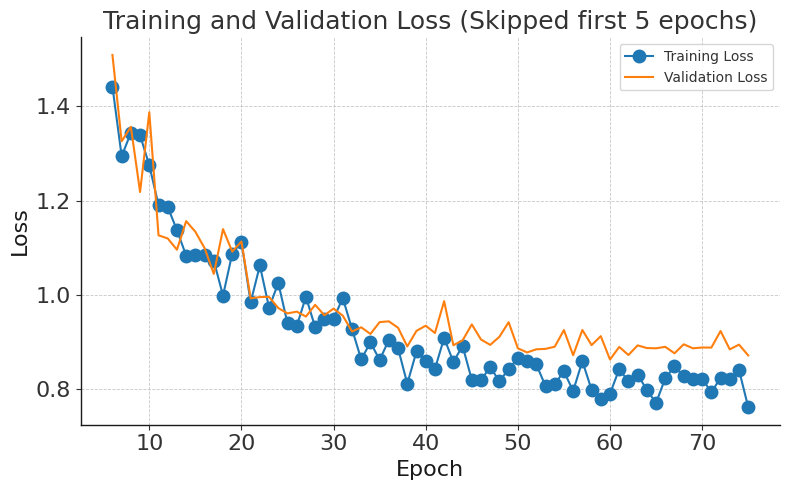

In [14]:
TRAIN = True
if TRAIN:
    custom_nn.seed_all()

    print("Training the model...")
    print('Model parameters:')
    for key, value in args.items():
        print(f"{key}: {value}")
    custom_nn.fit(dataset.X, dataset.y)
    # The dataset provided in fit is not used as the datasets are overwritten in the provided train_split function

    # Generate filename with current date
    current_date = datetime.now().strftime("%Y-%m-%d")
    model_filename = f"nn_model_{current_date}"

    plot_training_history(custom_nn, skip_first_n=5)

    # After Training: Best weights are already loaded
    # Save the model
    custom_nn.save_model(model_filename)
    
    # save params dic
    params_filename = f"nn_params_{current_date}.pkl"

    with open(f"models/{params_filename}", "wb") as f:
        pickle.dump(args, f)

else:
    # Load model and set to CPU
    model_filename = "nn_model_2025-07-30_east_west_split.pt"  # Replace with actual date if needed

    loaded_model = mbm.models.CustomNeuralNetRegressor.load_model(
        cfg,
        model_filename,
        **{
            **args,
            **param_init
        },
    )
    loaded_model = loaded_model.set_params(device='cpu')
    loaded_model = loaded_model.to('cpu')

In [12]:
# Load model and set to CPU
model_filename = "nn_model_2025-07-14_CH_flexible.pt"  # Replace with actual date if needed

loaded_model = mbm.models.CustomNeuralNetRegressor.load_model(
    cfg,
    model_filename,
    **{
        **args,
        **param_init
    },
)
loaded_model = loaded_model.set_params(device='cpu')
loaded_model = loaded_model.to('cpu')

### Load model and make predictions:

In [13]:
# Create features and metadata
features_test, metadata_test = loaded_model._create_features_metadata(
    df_X_test_subset)

# Ensure all tensors are on CPU if they are torch tensors
if hasattr(features_test, 'cpu'):
    features_test = features_test.cpu()

# Ensure targets are also on CPU
targets_test = test_set['y']
if hasattr(targets_test, 'cpu'):
    targets_test = targets_test.cpu()

# Create the dataset
dataset_test = mbm.data_processing.AggregatedDataset(cfg,
                                                     features=features_test,
                                                     metadata=metadata_test,
                                                     targets=targets_test)

dataset_test = [
    SliceDataset(dataset_test, idx=0),
    SliceDataset(dataset_test, idx=1)
]

# Make predictions aggr to meas ID
y_pred = loaded_model.predict(dataset_test[0])
y_pred_agg = loaded_model.aggrPredict(dataset_test[0])

batchIndex = np.arange(len(y_pred_agg))
y_true = np.array([e for e in dataset_test[1][batchIndex]])

# Calculate scores
score = loaded_model.score(dataset_test[0], dataset_test[1])
mse, rmse, mae, pearson = loaded_model.evalMetrics(y_pred, y_true)

# Aggregate predictions
id = dataset_test[0].dataset.indexToId(batchIndex)
data = {
    'target': [e[0] for e in dataset_test[1]],
    'ID': id,
    'pred': y_pred_agg
}
grouped_ids = pd.DataFrame(data)

# Add period
periods_per_ids = df_X_test_subset.groupby('ID')['PERIOD'].first()
grouped_ids = grouped_ids.merge(periods_per_ids, on='ID')

# Add glacier name
glacier_per_ids = df_X_test_subset.groupby('ID')['GLACIER'].first()
grouped_ids = grouped_ids.merge(glacier_per_ids, on='ID')

# Add YEAR
years_per_ids = df_X_test_subset.groupby('ID')['YEAR'].first()
grouped_ids = grouped_ids.merge(years_per_ids, on='ID')

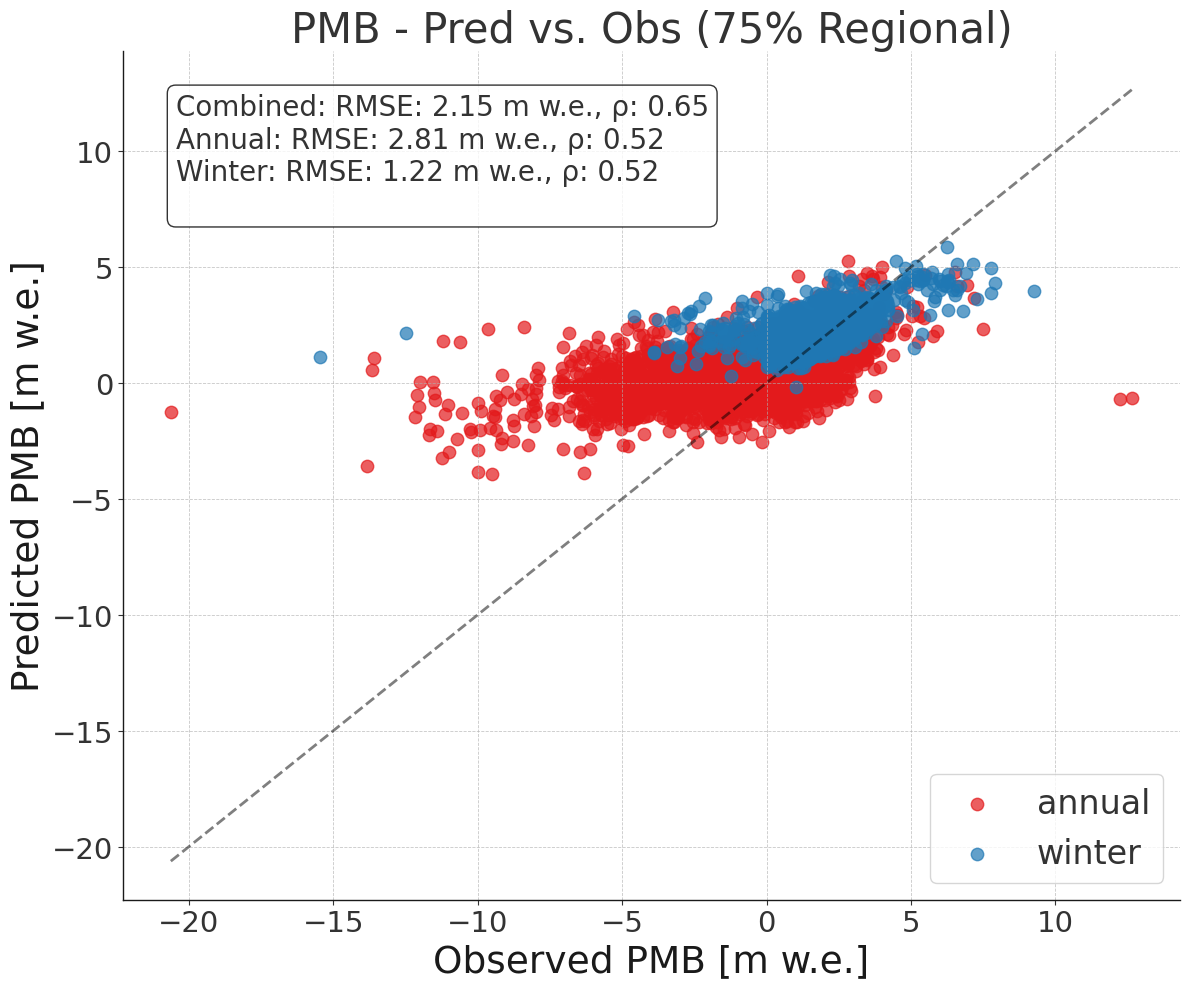

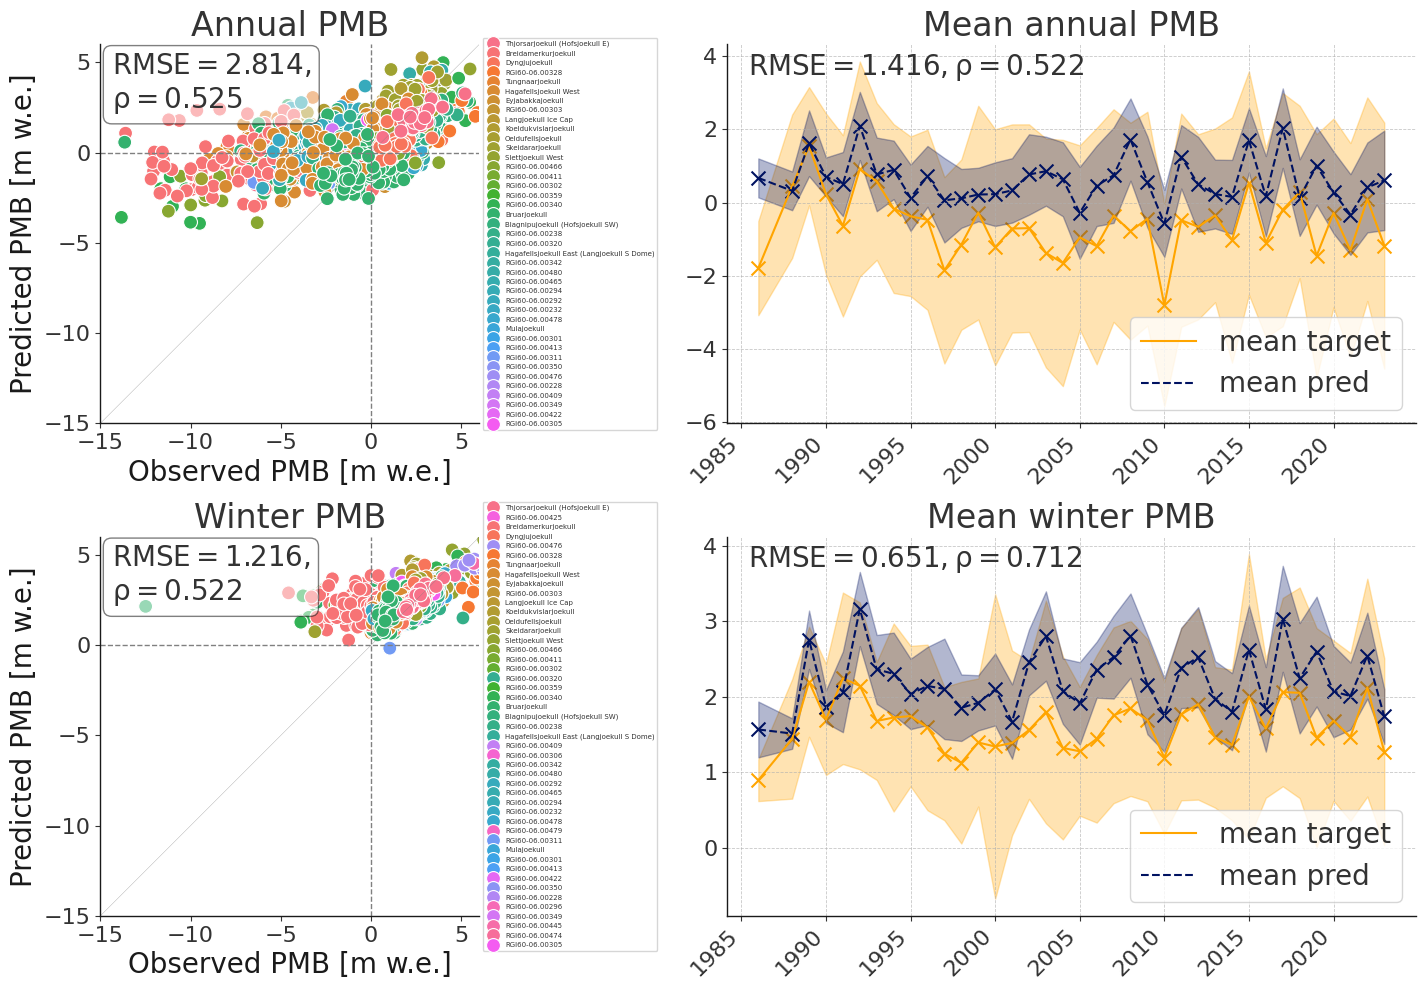

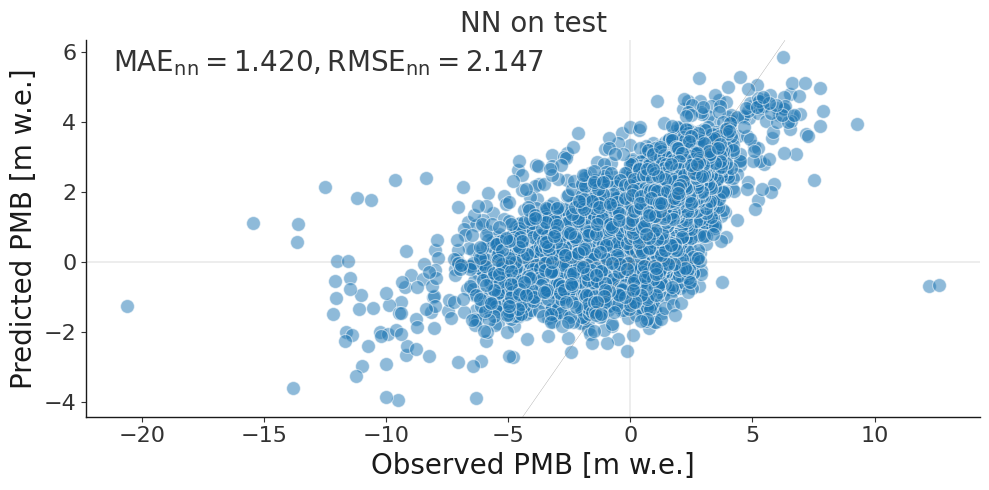

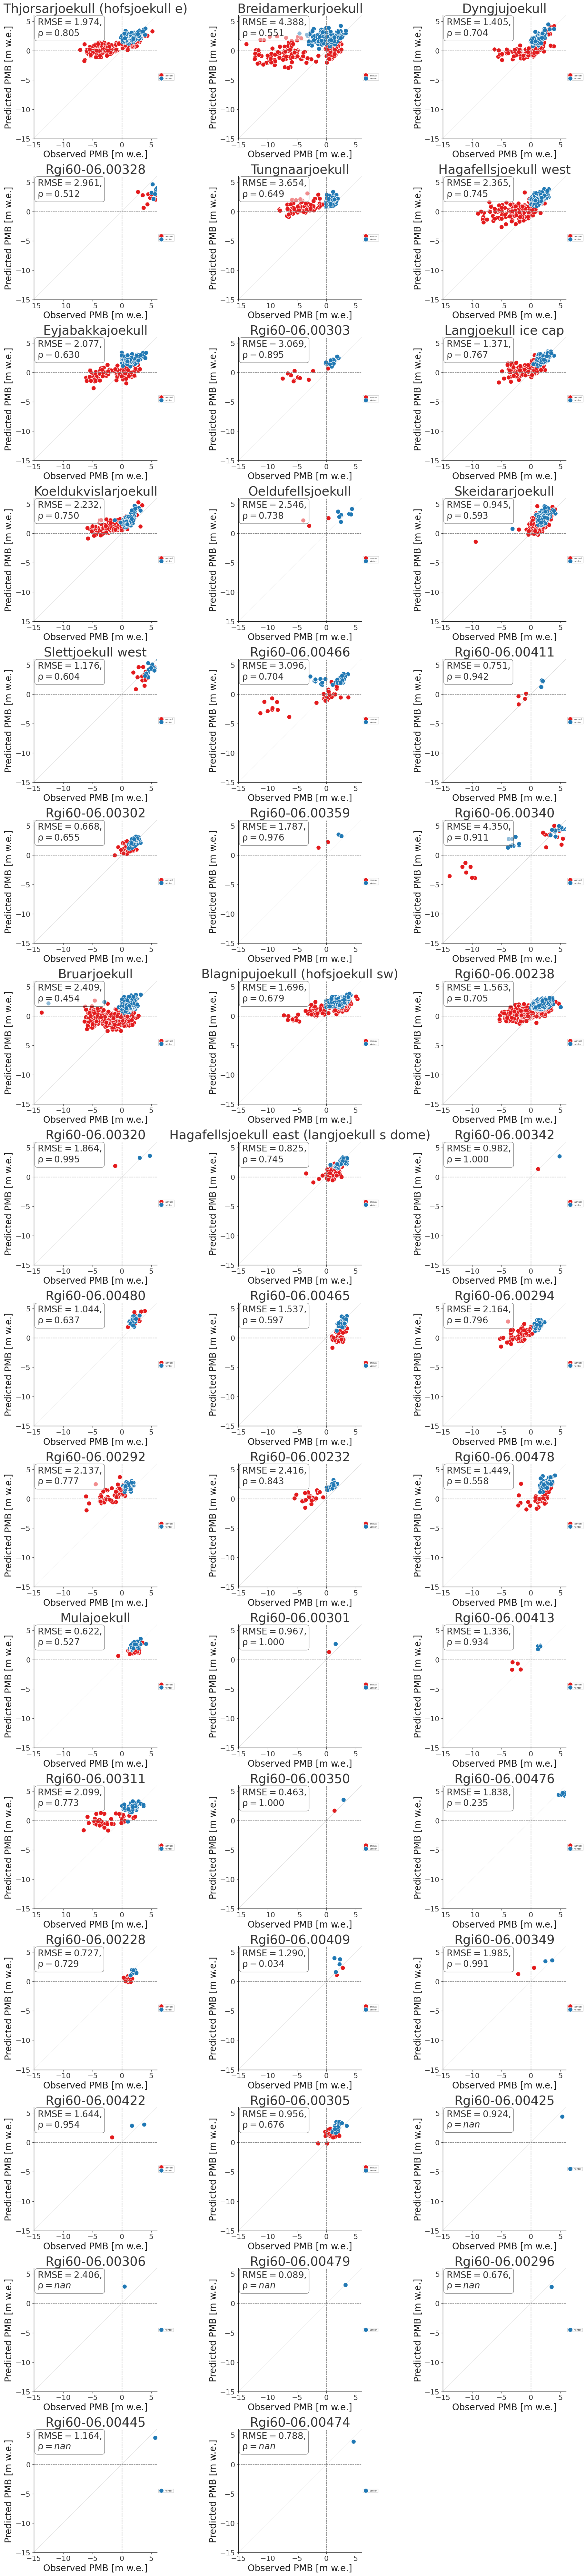

In [ ]:
PlotPredictionsCombined_NN(grouped_ids, region_name='CH Train ICE Test', include_summer=False)
PlotPredictions_NN(grouped_ids)
predVSTruth_all(grouped_ids, mae, rmse, title='NN on test')
PlotIndividualGlacierPredVsTruth(grouped_ids, base_figsize=(20, 15))